In [1]:
from data import temperature
from data import sample_HC
from data import err_sample_HC
from data import err_temperature

In [2]:
squared_temperature = temperature**2  # K**2
C_div_T = sample_HC/temperature  # mJ/K**2.mol
err_C_divT = err_sample_HC/temperature

In [3]:
N = 50  # Set N to the desired number of data points

temperature = temperature[:N]
sample_HC = sample_HC[:N]
err_sample_HC = err_sample_HC[:N]
squared_temperature = squared_temperature[:N]
C_div_T = C_div_T[:N]
err_C_divT = err_C_divT[:N]
err_temperature = err_temperature[:N]

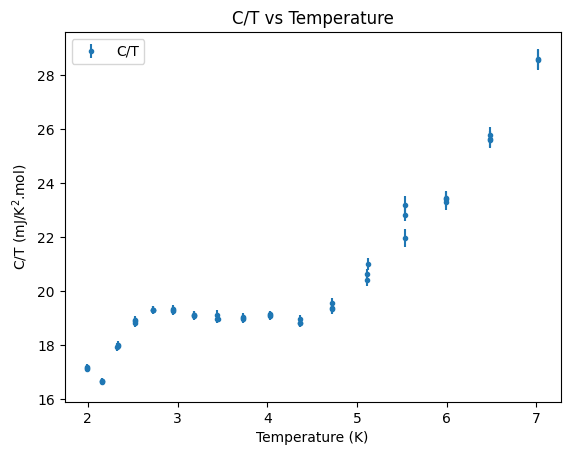

In [4]:
import matplotlib.pyplot as plt

plt.errorbar(temperature, C_div_T, yerr=err_C_divT, fmt='o', markersize=3, label='C/T')
plt.xlabel('Temperature (K)')
plt.ylabel('C/T (mJ/K$^2$.mol)')
plt.title('C/T vs Temperature')
plt.legend()
plt.show()

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Prepare data
X = temperature.reshape(-1, 1).astype('float32')
y = C_div_T.reshape(-1, 1).astype('float32')

max_degree = 5
best_loss = float('inf')
best_degree = None
best_model = None

for degree in range(1, max_degree + 1):  # K = 1 to max degree
    # Create polynomial features
    X_poly = np.concatenate([X**d for d in range(1, degree+1)], axis=1)
    
    model = keras.Sequential([
        layers.Input(shape=(degree,)),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(0.1), loss='mse')
    model.fit(X_poly, y, epochs=1000, verbose=0)
    
    val_loss = model.evaluate(X_poly, y, verbose=0)
    print(f"Degree {degree}, Validation Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        best_degree = degree
        best_model = keras.models.clone_model(model)
        best_model.set_weights(model.get_weights())

print(f"Best polynomial degree: {best_degree}, Loss: {best_loss:.4f}")


Degree 1, Validation Loss: 1.5320
Degree 2, Validation Loss: 1.1952
Degree 3, Validation Loss: 0.4674
Degree 4, Validation Loss: 0.8070
Degree 5, Validation Loss: 2.1887
Best polynomial degree: 3, Loss: 0.4674


7/7 [==============================] - 0s 2ms/step


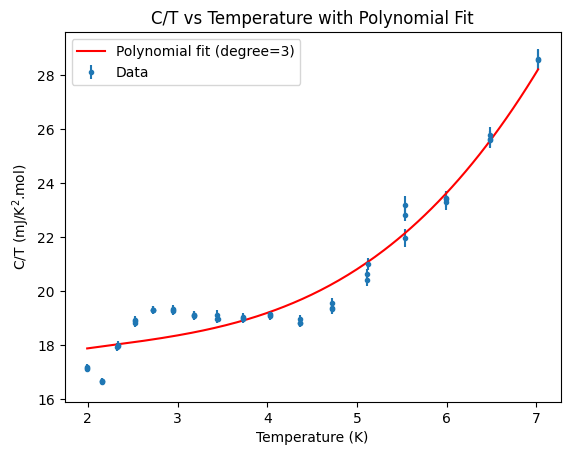

In [15]:
import numpy as np

# Predict using the best_model and plot the polynomial fit with the data points
import matplotlib.pyplot as plt

# Generate a smooth range of temperature values for plotting the polynomial curve
temperature_plot = np.linspace(temperature.min(), temperature.max(), 200).reshape(-1, 1)
# Create polynomial features up to best_degree for the plot
temperature_poly = np.concatenate([temperature_plot**d for d in range(1, best_degree+1)], axis=1)
# Predict C/T using the best_model
C_div_T_pred = best_model.predict(temperature_poly)

plt.errorbar(temperature, C_div_T, yerr=err_C_divT, fmt='o', markersize=3, label='Data')
plt.plot(temperature_plot, C_div_T_pred, 'r-', label=f'Polynomial fit (degree={best_degree})')
plt.xlabel('Temperature (K)')
plt.ylabel('C/T (mJ/K$^2$.mol)')
plt.title('C/T vs Temperature with Polynomial Fit')
plt.legend()
plt.show()